In [6]:
import numpy as np
import pandas as pd
from io import BytesIO
from azure.storage.blob import BlobServiceClient
from src.paychex_ml.utils import load_credentials
import matplotlib.pyplot as plt

In [7]:
credentials = load_credentials("blob_storage",
                               file="C:/Users/bruno.gonzalez/DataspellProjects/Paychex_revenue_forecast/credentials.yml")

In [8]:
# Start client
container_name = "clean-data"
blob_service_client = BlobServiceClient.from_connection_string(credentials['conn_string'])
container_client = blob_service_client.get_container_client(container_name)

# Download file
file = 'table_predictable.csv'
stream_downloader = container_client.download_blob(file)
with BytesIO() as stream:
    stream_downloader.readinto(stream)
    stream.seek(0)
    df = pd.read_csv(stream, dtype={'Period':str, 'Calendar Date': str})

In [10]:
items = ['401K Asset fee & BP Revenue',
         '401K Fee Revenue',
         'ASO Allocation',
         'ASO Revenue - Oasis',
         'Benetrac',
         'Cafeteria Plans Revenue',
         'Delivery Revenue',
         'Emerging Products',
         'ESR Revenue',
         'Full Service Unemployment Revenue',
         'Health Benefits',
         'HR Online',
         'HR Solutions (PEO)',
         'Interest on Funds Held for Clients',
         'Other Processing Revenue',
         'Payroll blended products',
         'SurePayroll.',
         'Time & Attendance',
         'Total international',
         'Total Paychex Advance',
         'Total PEO',
         'W-2 Revenue',
         'Workers Comp - Payment Services'
         ]

In [15]:
df = df[(df['Scenario']=='Actual')&(df['Item'].isin(items))]\
    .groupby(['Calendar Date', 'Item']).sum()\
    .unstack(level=1)['Value']

In [16]:
df.head()

Item,401K Asset fee & BP Revenue,401K Fee Revenue,ASO Allocation,ASO Revenue - Oasis,Benetrac,Cafeteria Plans Revenue,Delivery Revenue,ESR Revenue,Emerging Products,Full Service Unemployment Revenue,...,Interest on Funds Held for Clients,Other Processing Revenue,Payroll blended products,SurePayroll.,Time & Attendance,Total PEO,Total Paychex Advance,Total international,W-2 Revenue,Workers Comp - Payment Services
Calendar Date,,,,,,,,,,,,,,,,,,,,,
20140601,4261452.0,10621963.0,7255027.55,0.0,1922941.0,1714950.0,7393351.97,47602.0,796063.0,1869396.0,...,3308154.0,4765775.19,99633512.0,3246967.02,4651817.0,12948696.0,0.0,0.0,7031234.09,4858397.0
20140701,4513388.0,10558382.0,9070820.80,0.0,1916579.0,1698495.0,13513741.18,67521.0,986955.0,2341533.0,...,3466375.0,6502729.54,121619696.0,3362473.02,5165885.0,14670286.0,0.0,0.0,7325377.82,5244318.0
20140801,4486436.0,10297495.0,7489159.50,0.0,1944830.0,1829118.0,7286966.62,79771.0,924689.0,1986835.0,...,3434419.0,4215268.17,99472483.0,3286111.93,4856677.0,14606689.0,0.0,0.0,7443620.46,5588578.0
20140901,4355891.0,12719409.0,7011292.24,0.0,1933042.0,1710602.0,7081861.96,105330.0,732444.0,1888067.0,...,3419918.0,4726806.24,94198230.0,3345328.53,5098280.0,14456325.0,0.0,0.0,7414842.11,4968759.0
20141001,4455231.0,13797724.0,9372927.59,0.0,1956820.0,1702224.0,13741077.44,143956.0,1051920.0,2491011.0,...,3472038.0,6514037.07,124353873.0,3402641.78,5188982.0,14544813.0,0.0,0.0,7818212.35,5752070.0


In [13]:
df_external = pd.read_feather("ext_var_sel.feather").set_index('date')

# Model 401k Asset fee

In [17]:
item = '401K Asset fee & BP Revenue'
df_item = df[item]

In [18]:
df_item

Calendar Date
20140601    4261452.0
20140701    4513388.0
20140801    4486436.0
20140901    4355891.0
20141001    4455231.0
              ...    
20210101    8601656.0
20210201    8798633.0
20210301    9014864.0
20210401    8986182.0
20210501    9447456.0
Name: 401K Asset fee & BP Revenue, Length: 84, dtype: float64

In [145]:
def rename_sufix(df, sufix="_last"):

    d = dict(zip(df.columns, df.columns.map(lambda x: x  +sufix)))
    return d

In [147]:
df_external.shift(1).rename(columns=rename_sufix(df_external, "_last"))

,PSAVERT_last,FYFR_last,FYONET_last,FYFSD_last,CIVPART_last,INDPRO_last,ALTSALES_last,DGORDER_last,CP_last,HOUST_last,PERMIT_last,GASREGW_last,MHHNGSP_last,VIXCLS_last,STLFSI2_last,WBAA_last,MORTGAGE15US_last,DEXUSEU_last,DEXCHUS_last,DEXCAUS_last
date,,,,,,,,,,,,,,,,,,,,
20140601,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20140701,7.1,2.959388e+06,3.493328e+06,-5.339391e+05,62.8,102.5722,17.125,239998.0,1900.418780,911.0,1010.0,3.69160,4.59,11.541429,-0.884450,4.8025,3.2650,1.359486,6.230605,1.083038
20140801,7.2,2.979639e+06,3.497553e+06,-5.179132e+05,62.9,102.8479,16.851,304221.0,1917.769000,1085.0,1076.0,3.61125,4.05,12.296364,-0.789300,4.7400,3.2360,1.353336,6.198436,1.073918
20140901,7.0,3.000565e+06,3.501918e+06,-5.013531e+05,62.9,102.6491,16.808,235113.0,1904.742261,984.0,1047.0,3.48650,3.91,13.491905,-0.699140,4.6940,3.2475,1.331524,6.154129,1.092633
20141001,7.2,3.021491e+06,3.506284e+06,-4.847930e+05,62.8,102.9858,16.527,240539.0,1891.715522,1023.0,1077.0,3.40620,3.92,13.466667,-0.599750,4.7975,3.3075,1.288910,6.138229,1.101052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20210101,14.0,3.577222e+06,6.620630e+06,-3.043408e+06,61.5,98.2854,16.309,237428.0,2299.145000,1661.0,1758.0,2.19525,2.59,22.374091,-0.577075,3.1675,2.2180,1.216800,6.539295,1.280919
20210201,19.9,3.630385e+06,6.643464e+06,-3.013079e+06,61.4,99.4076,16.779,243160.0,2367.593000,1625.0,1883.0,2.33425,2.71,24.910000,-0.634300,3.2240,2.2000,1.217767,6.467178,1.272461
20210301,13.5,3.683548e+06,6.666297e+06,-2.982750e+06,61.5,96.3966,15.932,246261.0,2478.777944,1447.0,1726.0,2.50100,5.35,23.140526,-0.744350,3.4200,2.2375,1.209395,6.460058,1.269647


In [148]:
X = pd.concat([df_item.shift(1).rename("last"),
               df_item.shift(12).rename("t-12"),
               df_external.shift(1).rename(columns=rename_sufix(df_external, "_last"))],
              axis=1).dropna()
X

,last,t-12,PSAVERT_last,FYFR_last,FYONET_last,FYFSD_last,CIVPART_last,INDPRO_last,ALTSALES_last,DGORDER_last,...,PERMIT_last,GASREGW_last,MHHNGSP_last,VIXCLS_last,STLFSI2_last,WBAA_last,MORTGAGE15US_last,DEXUSEU_last,DEXCHUS_last,DEXCAUS_last
20150601,4845898.0,4261452.0,7.5,3.172923e+06,3.629317e+06,-4.563941e+05,62.9,100.8408,17.488,214062.0,...,1272.0,2.71825,2.85,13.338500,-0.359080,4.8380,3.0625,1.116735,6.203450,1.217640
20150701,4676384.0,4513388.0,7.4,3.192321e+06,3.645077e+06,-4.527563e+05,62.7,100.5063,17.401,235097.0,...,1379.0,2.80160,2.78,14.339545,-0.281175,5.1225,3.1925,1.122559,6.205200,1.236495
20150801,4844667.0,4486436.0,7.3,3.211093e+06,3.660329e+06,-4.492357e+05,62.6,101.1831,17.827,228622.0,...,1140.0,2.79350,2.84,14.352273,-0.170460,5.2000,3.2140,1.099741,6.208450,1.286314
20150901,4651703.0,4355891.0,7.3,3.230492e+06,3.676090e+06,-4.455979e+05,62.6,100.9115,17.940,224197.0,...,1165.0,2.63620,2.77,19.428095,0.099825,5.1775,3.1275,1.113614,6.338252,1.314724
20151001,5014236.0,4455231.0,7.4,3.249890e+06,3.691850e+06,-4.419600e+05,62.4,100.5680,17.833,218491.0,...,1144.0,2.36525,2.66,24.377143,0.201325,5.3425,3.0950,1.122852,6.367605,1.326581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20210101,8482353.0,7587396.0,14.0,3.577222e+06,6.620630e+06,-3.043408e+06,61.5,98.2854,16.309,237428.0,...,1758.0,2.19525,2.59,22.374091,-0.577075,3.1675,2.2180,1.216800,6.539295,1.280919
20210201,8601656.0,7521580.0,19.9,3.630385e+06,6.643464e+06,-3.013079e+06,61.4,99.4076,16.779,243160.0,...,1883.0,2.33425,2.71,24.910000,-0.634300,3.2240,2.2000,1.217767,6.467178,1.272461
20210301,8798633.0,6995226.0,13.5,3.683548e+06,6.666297e+06,-2.982750e+06,61.5,96.3966,15.932,246261.0,...,1726.0,2.50100,5.35,23.140526,-0.744350,3.4200,2.2375,1.209395,6.460058,1.269647
20210401,9014864.0,6409987.0,26.6,3.731566e+06,6.686921e+06,-2.955356e+06,61.5,99.1618,17.641,249467.0,...,1755.0,2.81040,2.62,21.843043,-0.631475,3.7375,2.3925,1.190161,6.510861,1.256896


In [149]:
y = df_item.filter(items = X.index)
y

Calendar Date
20150601    4676384.0
20150701    4844667.0
20150801    4651703.0
20150901    5014236.0
20151001    4576227.0
              ...    
20210101    8601656.0
20210201    8798633.0
20210301    9014864.0
20210401    8986182.0
20210501    9447456.0
Name: 401K Asset fee & BP Revenue, Length: 72, dtype: float64

In [150]:
train_size = round(len(X)*0.84)

In [151]:
X_train = X.iloc[:train_size,:]
y_train = y.iloc[:train_size]

In [152]:
X_test = X.iloc[train_size:,:]
y_test = y.iloc[train_size:]

In [153]:
y_test

Calendar Date
20200601    7095696.0
20200701    7614673.0
20200801    7551520.0
20200901    7747346.0
20201001    7793677.0
20201101    8000295.0
20201201    8482353.0
20210101    8601656.0
20210201    8798633.0
20210301    9014864.0
20210401    8986182.0
20210501    9447456.0
Name: 401K Asset fee & BP Revenue, dtype: float64

In [154]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [155]:
y_pred_lr = lr.predict(X_test)

In [156]:
from matplotlib.dates import DateFormatter

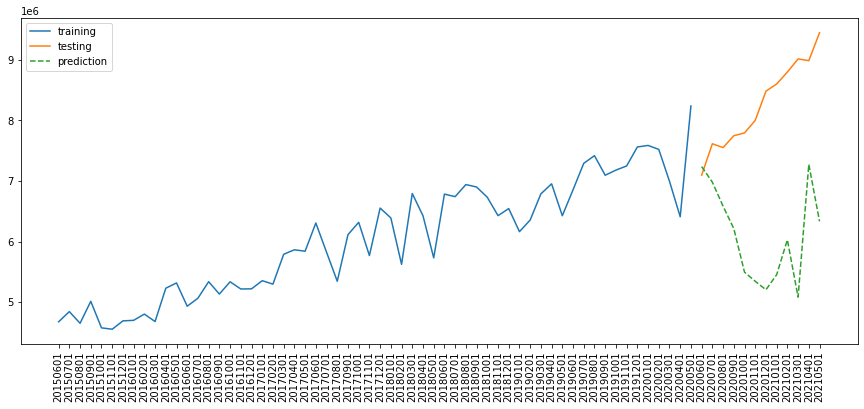

In [157]:
fig, ax = plt.subplots(figsize=(15,6))

# y_train.plot(ax=ax)
# y_test.plot(ax=ax)
ax.plot(y_train, label='training')
ax.plot(y_test, label='testing')
ax.plot(pd.DataFrame(y_pred_lr).set_index(y_test.index), label='prediction', ls="--")
# Define the date format
plt.xticks(rotation = 90)
plt.legend()

In [93]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [92]:
mean_absolute_error(y_test, y_pred_lr)

766042.3036576407

In [95]:
r2_score(y_test, y_pred_lr)

-0.27874318601170667